In [3]:
from one.api import ONE
import one
from utils import download_glm_hmm, save_data_path, val_eid

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib.patches as mpatches
import pickle


In [7]:
data = pd.read_pickle('data/ephys_glm_frame_data.pkl')

In [27]:
def count_max_prob_classes(frame_predictions):
    # Find the index of the max probability in each row
    max_indices = np.argmax(frame_predictions, axis=1)
    
    # Count occurrences of each index
    counts = np.bincount(max_indices, minlength=4)
    
    # Map counts to class names
    class_names = ["still", "move", "wheel_turn", "groom"]
    count_dict = {class_names[i]: counts[i] for i in range(4)}
    
    return count_dict

In [23]:
# plt.plot(data['frame_preds'].iloc[0])



for arr in data['frame_preds'].values:
    print(arr.shape)

    width = int(arr.shape[0] * 0.2)
    start = 0
    collect = []
    for i in range(5):
        collect.append(arr[start: start + width])
        
        start += width + 1


    print([len(x) for x in collect])

    
        
    break

(2378, 4)
[475, 475, 475, 475, 474]


In [31]:
count_dict = count_max_prob_classes(data['frame_preds'].values[0])
a = [count_dict, count_dict, count_dict, count_dict]

pd.DataFrame(a).to_dict('list')

{'still': [1151, 1151, 1151, 1151],
 'move': [279, 279, 279, 279],
 'wheel_turn': [948, 948, 948, 948],
 'groom': [0, 0, 0, 0]}

In [56]:
adf = pd.DataFrame()


for sess_id in val_eid:
    # Get the data for the session
    sess_data = data[data['session'] == sess_id]
    
    # for every trial of this session, get the frame predictions
    for i in range(len(sess_data)):
        # Get the data for this trial
        trial_data = sess_data.iloc[i]
        
        # Get the frame predictions
        frame_predictions = trial_data['frame_preds']

        # Count the number of occurrences of each class

        width = int(frame_predictions.shape[0] * 0.2)
        start = 0
        collect = []
        for j in range(5):
            count_dict = count_max_prob_classes(frame_predictions[start: start + width])
            collect.append(count_dict)
            start += width + 1
        count_dict = pd.DataFrame(collect).to_dict('list')
        # count_dict = {k: np.array(v) for k, v in pd.DataFrame(collect).to_dict('list').items()}


        # get the 3 state state model
        state_model = trial_data['glm-hmm_4']


        # rest of the columns
        rest = trial_data[[
            'session', 'trial_idx',
            'stimOnTrigger_times', 'repNum', 'goCueTrigger_times',
            'quiescencePeriod', 'contrastLeft', 'stimOn_times', 'feedback_times',
            'probabilityLeft', 'response_times', 'rewardVolume', 'choice',
            'goCue_times', 'firstMovement_times', 'contrastRight', 'feedbackType',
            'stimOff_times', 'intervals_0', 'intervals_1', 'intervals_bpod_0',
            'intervals_bpod_1', 'subject', 'included',
            'frame_start_index', 'frame_end_index']]

        # store them in the dataframe

        adf_ = pd.DataFrame({
            "state_1": [state_model[0]],
            "state_2": [state_model[1]],
            "state_3": [state_model[2]],
            "state_4": [state_model[3]],
            "most_likely_state": [['state_1', 'state_2', 'state_3', 'state_4'][np.argmax(state_model)]],
            'still': [count_dict['still']],
            'move': [count_dict['move']],
            'wheel_turn': [count_dict['wheel_turn']],
            'groom': [count_dict['groom']],
            **rest.to_dict()
        })

        adf = pd.concat([adf, adf_])



In [61]:
adf_ = adf.copy()
# adf.to_pickle('./data/adf1.pkle')

In [151]:
x = adf_[adf_['most_likely_state'] == "state_4"].copy()
x = x[['still', 'move', 'wheel_turn', 'groom']].values.tolist()
x = np.array(x)
x.T.shape
x.shape

(2118, 4, 5)

In [198]:
# we want 4, 4, 5
state_frame_probs=[]

for i, state in enumerate(['state_1', 'state_2', 'state_3', 'state_4']):
    
    state_data = adf[adf['most_likely_state'] == state]
    state_data = state_data[['still', 'move', 'wheel_turn', 'groom']].values.tolist()
    state_data = np.array(state_data)

    print(state_data.shape)
    all_counts = state_data.sum(axis=0)
    print(all_counts.shape)

    total_count = all_counts.sum(axis=0)
    print(total_count.shape)
    state_frame_probs.append(all_counts / total_count)

    
state_frame_probs = np.array(state_frame_probs)
print(state_frame_probs)


(2354, 4, 5)
(4, 5)
(5,)
(10550, 4, 5)
(4, 5)
(5,)
(14001, 4, 5)
(4, 5)
(5,)
(2118, 4, 5)
(4, 5)
(5,)
[[[0.76682628 0.77287839 0.75856946 0.76217283 0.76558914]
  [0.08399744 0.08112607 0.08168814 0.08232864 0.08225996]
  [0.14069288 0.13527692 0.14983421 0.14376032 0.1388968 ]
  [0.0084834  0.01071863 0.00990819 0.0117382  0.01325411]]

 [[0.74051804 0.74288954 0.73933286 0.74326136 0.74333062]
  [0.09762687 0.09673915 0.09644518 0.09521585 0.09642081]
  [0.15277342 0.15065289 0.15466389 0.15292563 0.15190567]
  [0.00908168 0.00971842 0.00955807 0.00859715 0.00834291]]

 [[0.72648247 0.72254548 0.72335314 0.72155584 0.7238824 ]
  [0.09771539 0.10325174 0.10008396 0.1021833  0.10055231]
  [0.16463564 0.16388708 0.16681941 0.16636821 0.16525033]
  [0.01116651 0.0103157  0.00974349 0.00989264 0.01031496]]

 [[0.79532822 0.78619175 0.78630368 0.79541917 0.78720701]
  [0.07202846 0.07304984 0.07296239 0.07188155 0.07356219]
  [0.12546216 0.13501838 0.13152399 0.1247346  0.13061317]
  [0.00

In [200]:
state_frame_probs = state_frame_probs.transpose(1, 0, 2)
state_frame_probs.shape

(4, 4, 5)

C:\Users\our\AppData\Local\Temp\ipykernel_5756\1309473428.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i//2, i%2].set_xticklabels([0, 0.2, 0.4, 0.6, 0.8, 1])
C:\Users\our\AppData\Local\Temp\ipykernel_5756\1309473428.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i//2, i%2].set_xticklabels([0, 0.2, 0.4, 0.6, 0.8, 1])
C:\Users\our\AppData\Local\Temp\ipykernel_5756\1309473428.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i//2, i%2].set_xticklabels([0, 0.2, 0.4, 0.6, 0.8, 1])
C:\Users\our\AppData\Local\Temp\ipykernel_5756\1309473428.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i//2, i%2].set_xticklabels([0, 0.2, 0.4, 0.

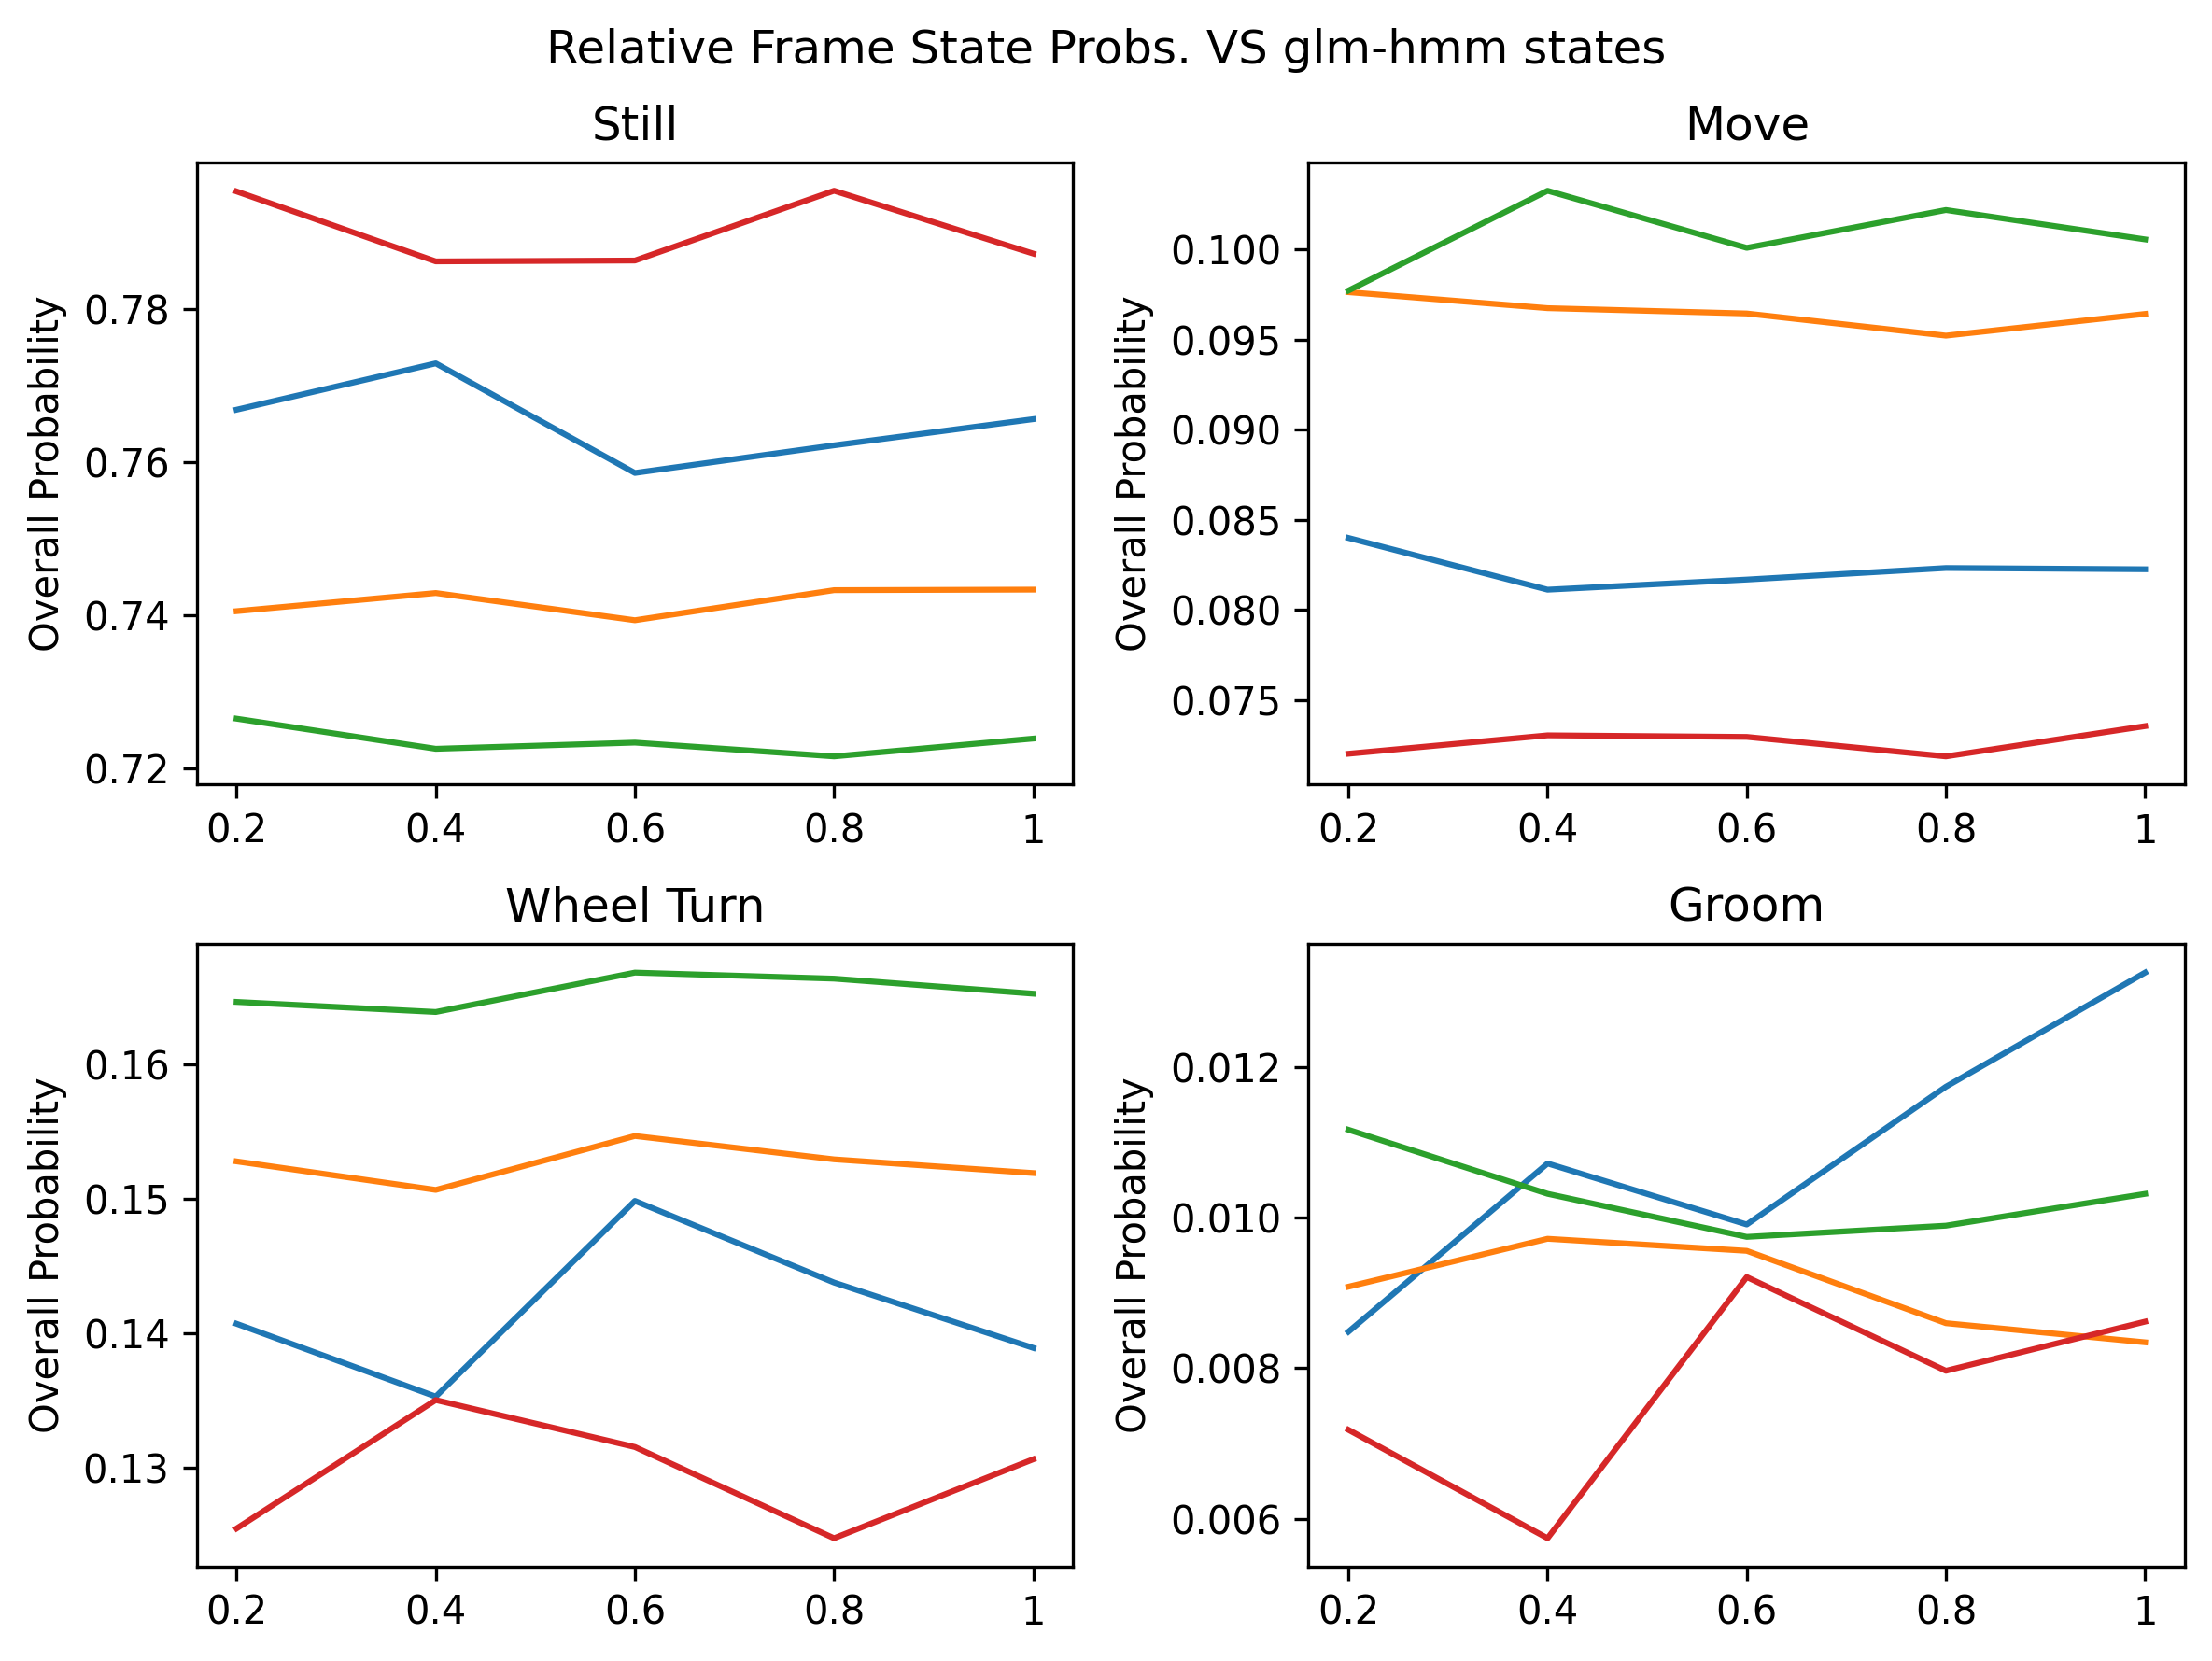

In [212]:
fig, ax = plt.subplots(2, 2, figsize=(8, 6), dpi=300)

# cmap = ["#DB504A", "#E3B505", "#4F6D7A", "#56A3A6"]

probs = np.array(state_frame_probs)

for i, frame in enumerate(['Still', 'Move', 'Wheel Turn', 'Groom']):
    ax[i//2, i%2].plot(probs[i].T)
    # print(f"{i}", probs[i])
    # ax[i//2, i%2].bar(['State 1', 'State 2', 'State 3', 'State 4'], probs[i], color=cmap)
    ax[i//2, i%2].set_xticklabels([0, 0.2, 0.4, 0.6, 0.8, 1])
    ax[i//2, i%2].set_title(frame)
    ax[i//2, i%2].set_ylabel('Overall Probability')

plt.tight_layout()
plt.suptitle('Relative Frame State Probs. VS glm-hmm states')
plt.subplots_adjust(top=0.9)
plt.show()